# Introduction:
*In this project, the goal is to classify dog and cat images using the Dogs vs. Cats dataset provided on Kaggle. A Convolutional Neural Network (CNN) model was trained to distinguish between the two classes using labeled image data.*

*The dataset was preprocessed by resizing and normalizing the images, and a supervised learning approach was applied. The model was trained using a multi-layer CNN and evaluated on a validation set before generating predictions on the test set.*



In [1]:
# Required libraries
import os
import random
import numpy as np
import cv2
import zipfile
import matplotlib.pyplot as plt
import pandas as pd


from imutils import paths
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array

2025-07-17 22:25:24.241877: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752791124.598719      18 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752791124.708750      18 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Define paths
zip_train_path = "/kaggle/input/dogs-vs-cats/train.zip"
zip_test_path = "/kaggle/input/dogs-vs-cats/test1.zip"
extract_train_path = "/kaggle/working/train"
extract_test_path = "/kaggle/working/test"

# Extract training data
with zipfile.ZipFile(zip_train_path, 'r') as zip_ref:
    zip_ref.extractall(extract_train_path)

# Extract test data
with zipfile.ZipFile(zip_test_path, 'r') as zip_ref:
    zip_ref.extractall(extract_test_path)

print("Train and test zip files extracted successfully.")

Train and test zip files extracted successfully.


In [3]:
# Data loading function
class_labels = {'cat': 0, 'dog': 1}  # Map class names to numeric labels

def load_dataset(path, target_size=(100, 100), max_samples=None):
    """
    Load images from the given directory, preprocess them, and return image arrays with labels.

    Parameters:
        path (str): Directory containing the images
        target_size (tuple): Desired image size (width, height) after resizing
        max_samples (int or None): Maximum number of samples to load

    Returns:
        x (np.array): Array of preprocessed images normalized to [0, 1]
        labels (np.array): Corresponding numeric labels
    """
    x = []           # List to store images
    labels = []      # List to store labels

    # Get all image file paths and shuffle them randomly
    image_paths = list(paths.list_images(path))
    random.shuffle(image_paths)
    
    # Limit number of samples to 2000 for faster processing
    image_paths = image_paths[:2000]
    if max_samples:
        image_paths = image_paths[:max_samples]

    for image_path in image_paths:
        img = cv2.imread(image_path)
        if img is None:
            print(f"Warning: {image_path} could not be read, skipping.")
            continue

        img = cv2.resize(img, target_size)  
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        x.append(img)

        # Determine label from filename prefix
        file_name = os.path.basename(image_path)
        if file_name.startswith('cat'):
            label_name = 'cat'
        elif file_name.startswith('dog'):
            label_name = 'dog'
        else:
            print(f"Warning: Unknown file format {file_name}, skipping.")
            continue

        labels.append(class_labels[label_name])

    # Convert lists to numpy arrays and normalize pixel values to range [0, 1]
    x = np.array(x, dtype="float32") / 255.0
    labels = np.array(labels)

    print(f"Loaded data shape: {x.shape}, Number of labels: {len(labels)}")
    return x, labels

In [4]:
def visualize_img(image_batch, label_batch, class_labels=class_labels):
    """
    Displays a sample of images with their corresponding labels.
    
    Parameters:
        image_batch (array-like): Batch of images (e.g., x_train)
        label_batch (array-like): Corresponding labels (e.g., y_train)
        class_labels (dict): Dictionary mapping class names to numeric labels
    """

    plt.figure(figsize=(12, 6))  # Set the figure size
    class_names = list(class_labels.keys())  # Get class names (e.g., ['cat', 'dog'])

    # Select 10 random indices (or less if fewer images are available)
    sample_size = min(10, len(image_batch))
    idxs = np.random.choice(len(image_batch), size=sample_size, replace=False)

    for i, idx in enumerate(idxs):
        ax = plt.subplot(2, 5, i + 1)  # Arrange in 2 rows and 5 columns
        plt.imshow(image_batch[idx])  # Show the image
        plt.title(class_names[label_batch[idx]].title())  # Display the label
        plt.axis('off')  # Hide axis ticks

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()  # Display the plot

# Load the dataset
x_train, y_train = load_dataset(extract_train_path)

Loaded data shape: (2000, 100, 100, 3), Number of labels: 2000


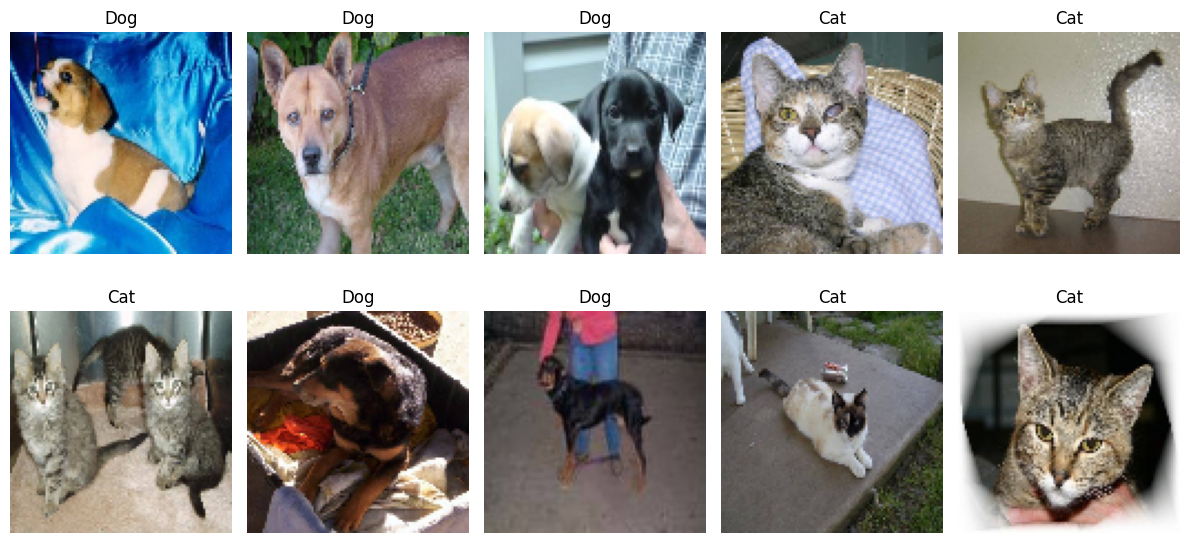

In [5]:
visualize_img(x_train, y_train)

In [6]:
X, y = load_dataset(extract_train_path, max_samples=2000)

Loaded data shape: (2000, 100, 100, 3), Number of labels: 2000


In [7]:
#  Load test dataset (without labels)
test_path = os.path.join(extract_test_path, "test1")
test_image_paths = sorted(list(paths.list_images(test_path)), key=lambda x: int(os.path.splitext(os.path.basename(x))[0]))
X_test = []

# Load and preprocess each test image
for img_path in test_image_paths:
    img = cv2.imread(img_path)
    img = cv2.resize(img, (100,100))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    X_test.append(img)

X_test = np.array(X_test, dtype="float32") / 255.0

In [8]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
# Build the model
IMG_SIZE = 100

#Define a simple Convolutional Neural Network using the Sequential API
model = Sequential([
    Conv2D(8, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),  # First convolutional layer
    MaxPooling2D(2, 2),  # First max pooling layer

    Conv2D(16, (3, 3), activation='relu'),  # Second convolutional layer
    MaxPooling2D(2, 2),  # Second max pooling layer

    Flatten(),  # Flatten the 3D feature maps to 1D
    Dense(64, activation='relu'),  # Fully connected layer with 64 units
    Dropout(0.5),  # Dropout layer to prevent overfitting

    Dense(1, activation='sigmoid')  # Output layer with sigmoid activation for binary classification
])

# Compile the model with appropriate loss function and optimizer
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1752791172.178453      18 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1752791172.179093      18 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 98, 98, 8)      │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 49, 49, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 47, 47, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 23, 23, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8464)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       541,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 543,217 (2.07 MB)

 Trainable params: 543,217 (2.07 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=8,
    verbose=2
)

Epoch 1/10


I0000 00:00:1752791176.301114      64 service.cc:148] XLA service 0x7e9974002bf0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752791176.302475      64 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1752791176.302496      64 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1752791176.661782      64 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1752791179.629944      64 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


200/200 - 6s - 32ms/step - accuracy: 0.5581 - loss: 0.6852 - val_accuracy: 0.6475 - val_loss: 0.6483
Epoch 2/10
200/200 - 1s - 3ms/step - accuracy: 0.6538 - loss: 0.6379 - val_accuracy: 0.6750 - val_loss: 0.6288
Epoch 3/10
200/200 - 1s - 4ms/step - accuracy: 0.7006 - loss: 0.5828 - val_accuracy: 0.6500 - val_loss: 0.6335
Epoch 4/10
200/200 - 1s - 4ms/step - accuracy: 0.7494 - loss: 0.5281 - val_accuracy: 0.6700 - val_loss: 0.6032
Epoch 5/10
200/200 - 1s - 4ms/step - accuracy: 0.7931 - loss: 0.4562 - val_accuracy: 0.6775 - val_loss: 0.6187
Epoch 6/10
200/200 - 1s - 4ms/step - accuracy: 0.8338 - loss: 0.3771 - val_accuracy: 0.6450 - val_loss: 0.7016
Epoch 7/10
200/200 - 1s - 4ms/step - accuracy: 0.8656 - loss: 0.3082 - val_accuracy: 0.6625 - val_loss: 0.6897
Epoch 8/10
200/200 - 1s - 4ms/step - accuracy: 0.9094 - loss: 0.2389 - val_accuracy: 0.6625 - val_loss: 0.8656
Epoch 9/10
200/200 - 1s - 4ms/step - accuracy: 0.9344 - loss: 0.1866 - val_accuracy: 0.6700 - val_loss: 0.9234
Epoch 10/10

**Training Summary:**
* The model starts with an accuracy near random chance (~50%) and improves steadily over the epochs. Training accuracy reaches around 93% by the 10th epoch, while validation accuracy plateaus around 67%.

* The validation loss shows some fluctuations and increases toward the end, indicating possible overfitting. This suggests the model fits the training data well but generalizes moderately on unseen data.

* To improve performance, techniques like EarlyStopping, data augmentation, or transfer learning could be applied.



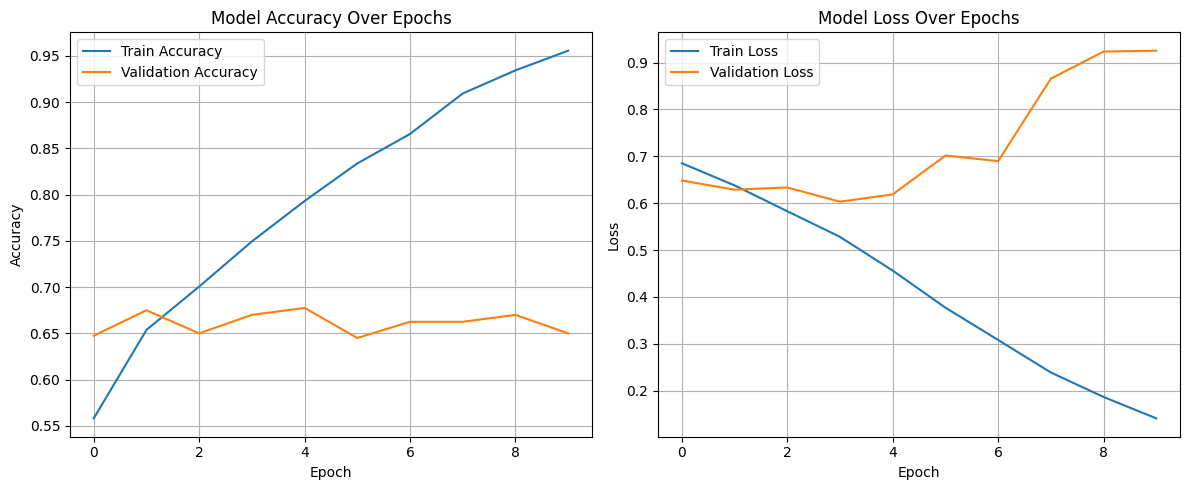

In [11]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [12]:
# Training results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

In [13]:
def predict_image(image_path, model, target_size=(100, 100)):
    """
    Load an image, preprocess it, and predict whether it's a cat or dog using the trained model.
    
    Parameters:
        image_path (str): Path to the image file.
        model (keras.Model): Trained CNN model for prediction.
        target_size (tuple): Desired image size for the model input.
    """

    # Load the image and resize it to the target size
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img) / 255.0  # Normalize pixel values to [0,1]
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension: (1, IMG_SIZE, IMG_SIZE, 3)

    # Make prediction using the model
    prediction = model.predict(img_array)[0][0]

    # Classification threshold set at 0.75
    label = "Dog" if prediction > 0.75 else "Cat"
    confidence = prediction if prediction > 0.75 else 1 - prediction

    # Print the prediction and confidence percentage
    print(f"Prediction: {label} ({confidence * 100:.2f}%)")

    # Display the image with the predicted label as the title
    plt.imshow(img)
    plt.title(f"Prediction: {label}")
    plt.axis('off')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step
Prediction: Dog (99.42%)


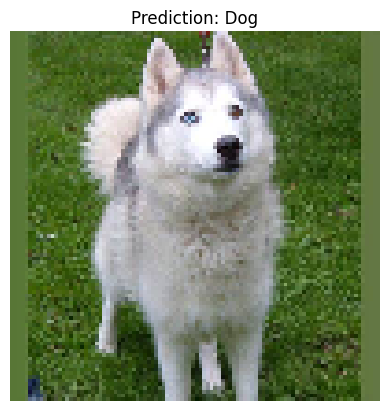

In [14]:
predict_image('/kaggle/working/train/train/dog.310.jpg', model)

In [15]:
# Predict probabilities on test set
predictions = model.predict(X_test)

391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


In [16]:
# Convert probabilities to binary labels (0 = cat, 1 = dog)
labels = (predictions > 0.5).astype(int).flatten()

# Extract image IDs from filenames
image_ids = [int(os.path.splitext(os.path.basename(path))[0]) for path in test_image_paths]

# Prepare submission DataFrame
submission = pd.DataFrame({
    "id": image_ids,
    "label": labels
})

# Sort by ID
submission = submission.sort_values(by="id")

# Save to CSV
submission.to_csv("submission.csv", index=False)
print(" submission.csv file created successfully!")

 submission.csv file created successfully!


# Conclusion
Despite training on a limited dataset, the model was able to make accurate predictions on the test images. The accuracy and loss curves indicate a balanced learning process without severe overfitting.

While the model's performance is satisfactory, improvements could be made using deeper networks, transfer learning techniques, or data augmentation to increase generalization.

This project demonstrates the implementation of a basic CNN model for solving image classification problems effectively.
